# Fokker-Planck Equation

### Matrix initialization refactor

Currently, the diffusion matrices are initialized using a native python list comprehension. This is inefficient from a computational perspective, and in this notebook we attempt to improve upon this process by translating the initialization into lower-level python libraries (`numpy`).

**Note** That the suggestions ultimately implemented by this notebook have been implemented, and so the prior *default* behaviour is performed by the `legacy` methods. Further, those methods, being depreciated, have been removed from the source code and so this notebook will most likely not run on bracnhes other than the current (and not tracked) development branch `matrix-init-refactor`

In [1]:
# First import the FPE library
import os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from FPE.Integrator import FPE_Integrator_1D
sns.set(style="darkgrid", palette="hls")

proj_dir = Path().resolve().parents[1]
fig_dir = os.path.join(proj_dir, "figures", "diagnostics")

D = 1.0
dt = 0.01
dx = 0.2
x_array = np.arange(0, 1, dx)

# Firsty, start with open boundaries os that there is no influence from the BCs
fpe = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond='open')

In [2]:
fpe.initDiffusionMatrix_legacy()
fpe.AMat


array([[ 1.25 , -0.125,  0.   ,  0.   ,  0.   ],
       [-0.125,  1.25 , -0.125,  0.   ,  0.   ],
       [ 0.   , -0.125,  1.25 , -0.125,  0.   ],
       [ 0.   ,  0.   , -0.125,  1.25 , -0.125],
       [ 0.   ,  0.   ,  0.   , -0.125,  1.25 ]])

Simply, this ia a tridiagonal matrix, with diagonal terms given by 

$$ A_{ii} = 1 + 2\alpha*\beta $$

where $\alpha = D \Delta t / (\Delta x)^2$ is determined by input parameters, and $\beta \in [0, 1]$ is the splitting fraction between explicit (0) and implicit (1) schemes (which defaults to the Crank-Nicolson avlue of 1/2).

the off diagonal terms are 

$$ A_{i, i\pm 1} = -\alpha\beta $$

So, we can initialize this matrix by simply adding together three diagonal matrices, generate using `numpy`


In [3]:
alpha = D * dt / (dx * dx)
beta = 0.5

AMat_alt = (
    np.diag(1 + 2 * alpha * beta * np.ones(len(x_array)))
    + np.diag(-1 * alpha * beta * np.ones(len(x_array)-1), k=1)
    + np.diag(-1 * alpha * beta * np.ones(len(x_array)-1), k=-1)
)

AMat_alt

array([[ 1.25 , -0.125,  0.   ,  0.   ,  0.   ],
       [-0.125,  1.25 , -0.125,  0.   ,  0.   ],
       [ 0.   , -0.125,  1.25 , -0.125,  0.   ],
       [ 0.   ,  0.   , -0.125,  1.25 , -0.125],
       [ 0.   ,  0.   ,  0.   , -0.125,  1.25 ]])

In [4]:
# Now, we can look at timing the initialization on the list comprehension and numpy 'version'
# in the open boundary conditions, for various grid sizes

dx = 0.01
x_array = np.arange(0, 1, dx)
fpe = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond='open')

# This matric is now the default 'initDiffusionMatrix' routine in the integrator
def initDiffusionMatrix_alt(alpha, beta, x_array):
    _ = (
        np.diag(1 + 2 * alpha * beta * np.ones(len(x_array)))
        + np.diag(-1 * alpha * beta * np.ones(len(x_array)-1), k=1)
        + np.diag(-1 * alpha * beta * np.ones(len(x_array)-1), k=-1)
    )

In [5]:
%timeit fpe.initDiffusionMatrix_legacy()

3.73 ms ± 60.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [6]:
res = %timeit -o fpe.initDiffusionMatrix()

571 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [7]:
# Now lets look at this scaling with grid dimension
N = [2 ** i * 5 for i in range(10)]

time_legacy = []
err_legacy = []
time_alt = []
err_alt = []

for n in N:
    x_array = np.linspace(0, 1, n)
    dx = x_array[1] - x_array[0]
    alpha = D * dt / (dx * dx)
    fpe = FPE_Integrator_1D(D, dt, dx, x_array)
    res_leg = %timeit -o fpe.initDiffusionMatrix_legacy()
    res_alt = %timeit -o fpe.initDiffusionMatrix()

    time_legacy.append(res_leg.average)
    time_alt.append(res_alt.average)

    err_legacy.append(res_leg.stdev)
    err_alt.append(res_alt.stdev)


41.3 µs ± 4.84 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
74.3 µs ± 862 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
90.7 µs ± 2.27 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
94.8 µs ± 1.83 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
213 µs ± 6.18 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
113 µs ± 3.03 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
650 µs ± 6.15 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
174 µs ± 2.8 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)
2.42 ms ± 21.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
423 µs ± 22.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
9.42 ms ± 99.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.34 ms ± 36.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
40.4 ms ± 562 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.8 ms ± 58.2 µs per loop (mean ± std. dev. of 

Text(0, 0.5, 'Initialization time (seconds)')

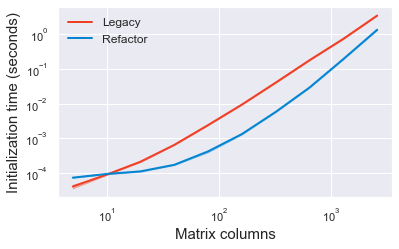

In [8]:
# And now we can plot the timed results to investigate
fig, ax = plt.subplots(1, 1, figsize=(6, 3.5))

ax.fill_between(N, np.array(time_legacy) + np.array(err_legacy), np.array(time_legacy) - np.array(err_legacy), color=sns.xkcd_rgb["tomato"], alpha=0.3)
ax.fill_between(N, np.array(time_alt) + np.array(err_alt), np.array(time_alt) - np.array(err_alt), color=sns.xkcd_rgb["cerulean"], alpha=0.3)

ax.plot(N, time_legacy, linewidth=2.0, color=sns.xkcd_rgb["tomato"], label="Legacy")
ax.plot(N, time_alt, linewidth=2.0, color=sns.xkcd_rgb["cerulean"], label="Refactor")

ax.legend(fontsize=12, frameon=False)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlabel(r"Matrix columns", fontsize=15)
ax.set_ylabel(r"Initialization time (seconds)", fontsize=15)



So, here we can see that there is a speedup of over two orders of magnitude asymptotically with the numpy-based initialization. This is largely expected, as list comprehensions are pure python in their execution (and further act on the most inefficient aspects of python at that), while the `numpy` based initialization is largely working off of the `C`-based backend of the highly optimized `numpy` library.

In the background, I have updated the implementations of the matrix initialization in the integrator code, so the final step will be to check that the two routines generate the same matrices for all boundary conditions, and then delete the depricated code, and submit the modifications to the master branch

In [9]:
# Checks
dx = 0.1
x_array = np.arange(0, 1, dx)
fpe = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond="open")
fpe.initDiffusionMatrix_legacy()
A_leg = fpe.AMat.copy()
B_leg = fpe.BMat.copy()

fpe.initDiffusionMatrix()
A_new = fpe.AMat.copy()
B_new = fpe.BMat.copy()

In [10]:
(A_leg == A_new).all(), (B_leg == B_new).all()

(True, True)

In [11]:
fpe = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond="periodic")
fpe.initDiffusionMatrix_legacy()
A_leg = fpe.AMat.copy()
B_leg = fpe.BMat.copy()

fpe.initDiffusionMatrix()
A_new = fpe.AMat.copy()
B_new = fpe.BMat.copy()

In [12]:
(A_leg == A_new).all(), (B_leg == B_new).all()

(True, True)

In [13]:
fpe = FPE_Integrator_1D(D, dt, dx, x_array, boundaryCond="hard-wall")
fpe.initDiffusionMatrix_legacy()
A_leg = fpe.AMat.copy()
B_leg = fpe.BMat.copy()

fpe.initDiffusionMatrix()
A_new = fpe.AMat.copy()
B_new = fpe.BMat.copy()

In [14]:
(A_leg == A_new).all(), (B_leg == B_new).all()

(True, True)